
# Sentiment - Analyser #

The "score" attribute we stored in every comment entry inside our database is already
a ruff estimation of the sentiment of a comment.<br>
However, this score can currently be any number which can vary substantially depending on the number
of likes a comment received... <br>
Besides that there is also the observation that a high like to dislike ratio on
youtube videos is the defacto standard, this is because human being mostly tend
to like positivity. :) <br>
Therefore we need to to the two following things in order to get a "true" sentiment: <br>

- normalize so that the sentiment is between 0 and 1 (for all comments of a video)

- shift the score a little so that a sentiment of 0.7 is more like 0.5

In [192]:
def sentiment_from_score(video_likes, video_dislikes, min_score, max_score, score):
        ratio = float(video_likes)/(float(video_likes)+float(video_dislikes))
        score, min_score, max_score = float(score), float(min_score), float(max_score)
        scaler = max_score - min_score
        if scaler == 0.0 : scaler = 1
        normalized_score = (( score - min_score ) / scaler) / 2
        assert normalized_score <= 0.5 and normalized_score >= 0.0
        capper = min(1, ratio/0.75)**2 
        normalized_score =  capper * 0.5 + normalized_score
        assert normalized_score <= 1 and normalized_score >= 0.0 
        return normalized_score

## Loading Data ##

Before starting with the machine learning and sentiment analysis
we first have to load the data and clean it! <br>
We store the data in the following 5 variables: <br>

- `video_max_comment_score` : A dictionary which ought to hold the largest score per video (of all comments). 

- `video_min_comment_score` : A dictionary which ought to hold the smallest score per video (of all comments).

- `comments` : A list of all comments (included the pre-pended video title).

- `sentiments` : A list of all sentiments calculated from the comment scores.

- `all_words` : A list of all words which will later be counted...

In [193]:

from neo4j import GraphDatabase

uri, user, password = 'bolt://localhost:11005', 'neo4j', 'neo4j_'

driver = GraphDatabase.driver(uri, auth=(user, password))
  
video_max_comment_score = dict()
video_min_comment_score = dict()
comments = []
sentiments = []
all_words = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (n:Author)-[c:COMMENTED]->(v:Video) RETURN n, c, v") # remove all graphs and nodes! BE CAREFUL!
 
    records = []

    # First! : We need to do some normalization!
    # Let's find the min/max scores for every video
    for record in result:
        if record['v']['title'] not in video_max_comment_score:
            video_max_comment_score[record['v']['title']] = float(record['c']['score'])
        elif float(video_max_comment_score[record['v']['title']]) > float(record['c']['score']):
            video_max_comment_score[record['v']['title']] = float(record['c']['score'])

        if record['v']['title'] not in video_min_comment_score:
            video_min_comment_score[record['v']['title']] = float(record['c']['score'])
        elif float(video_min_comment_score[record['v']['title']]) < float(record['c']['score']):
            video_min_comment_score[record['v']['title']] = float(record['c']['score'])
            
        if float(record['c']['likes']) > 0 :
            records.append(record)

    for record in records:
        normalized_score = sentiment_from_score(
            record['v']['likes'], 
            record['v']['dislikes'], 
            video_min_comment_score[record['v']['title']], 
            video_max_comment_score[record['v']['title']], 
            record['c']['score']
        )
        sentiments.append(normalized_score)
        
        newComment = (
            ("%s | %s" % (record['v']['title'],record['c']['text'])).lower()
            #record['c']['text'].lower()
            .replace('❤️', ' heart ').replace('💯', ' 100 ').replace('❤', ' heart ')
            .replace('🙏', ' pray ').replace('😘', ' kiss ').replace('🤗', ' happy ')
            .replace('💥', ' boom ').replace('✔️', ' like ').replace('😍', ' love ')
            .replace('🐱', ' cat ').replace('💔', ' broken heart ').replace('😵', ' confused ') 
            .replace('😄', ' awesome ').replace('👍', ' thumbs up ').replace('😎', ' cool ')
            .replace('🐷', ' pig ').replace('🤘', " rock'n roll ").replace('🤣', ' laughing hard ')
            .replace('😩', ' oh no ').replace('💎', ' diamond ').replace('😊', ' nice ')
            .replace('☺️', ' very nice ').replace('🙃', ' upside down smile ').replace('🤔', ' not sure ')
            .replace('😂', ' laughing ').replace('🙋🏻‍♀️',' hi ').replace('🥰', ' lovely ').replace('🥺',' sad ')
            .replace('!!!!', '!').replace('!!!', '!').replace('!!', '!')
            .replace('????', '?').replace('???', '?').replace('??', '?')
            .replace('oooo','o').replace('oooo','o').replace('ooo','o')
            .replace('..','...').replace('......','...').replace('....','...').replace('....','...').replace('...',' ... ')
            .replace('    ', ' ').replace('   ', ' ').replace('  ', ' ')
            .split() 
        )
        #print(newComment, "-|-", float(record['c']['score'])) 
        comments.append(newComment)
        all_words.extend(newComment)
    
    #---------------------------------------
driver.close()
 
#from pprint import pprint
#pprint(comments)
    

In [194]:
print(comments[56])
print(sentiments[56])

['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', 'i', 'love', 'how', 'the', 'comment', 'section', 'is', 'all', 'about', 'youtube', 'rewind', '2018,', 'and', 'not', 'one', 'about', 'the', 'actual', 'song.']
0.8102324470117477


In [195]:
print(comments[99])
print(sentiments[99])

['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', '1:12', 'drake']
0.8118713233686544


Let's see try to find the comment with the worst sentiment:

In [196]:
worst_i = -1
worst_score = 1
for i, score in enumerate( sentiments ):
    #print(i,score)
    if score < worst_score : 
        worst_score = score
        worst_i = i
        
print(comments[worst_i])
print(sentiments[worst_i])

['cuties', '|', 'official', 'trailer', '|', 'netflix', '|', 'i', 'already', 'knew', 'it', 'jeffrey', 'epstein', 'is', 'alive', 'he', 'is', 'directing', 'movies', 'now']
2.6422966043410494e-05


## Clean the Comments with Spark ##

The comments are currently still full of redundancies and
many uncommon tokens / words.
In order to be able to filter the comments we use spark to count their occurrences. <br>
After that we can remove the uncommon ones...

In [197]:
from pyspark import SparkContext
 
sc = SparkContext("local", "First App")
 
wordsRDD = sc.parallelize(all_words, 6)

zipped = (wordsRDD
            .map(lambda word : (word,1))
            .reduceByKey( lambda a, b : a+b )
            .collect())
sc.stop()                  

occurrences = {}

for word, count in zipped:
    occurrences[word] = count

print('Total number of unique words:', len(occurrences))

Total number of unique words: 21326


...and now let's remove rare tokens / words in order to cap the maximum amount of possible words a bit...

In [198]:
min_times = int(max(len(occurrences)/1750, 6))
print('One word should exist at least ',min_times,' times!')

def more_than_three(word):
    return occurrences[word] > min_times

for i, comment in enumerate(comments): 
    comments[i] = list(filter(more_than_three, comment))

One word should exist at least  12  times!


We also filter all comments which are under and over a certain size
in order to make training easier. <br>
Then we store the cleaned data into the following variables: <br>

- `clean_comments`

- `clean_sentiments`

In [199]:

def removed_short_comments(all_comments, all_sentiments):
    new_comments, new_sentiments = [], []
    
    for i, comment in enumerate(all_comments): 
        if len(comment) > 5 and len(comment) < 32 :
            new_comments.append(comment)
            new_sentiments.append(all_sentiments[i])
        
    return new_comments, new_sentiments

print('Number of comments before trimming:',len(comments))
print('Number of sentiments before trimming:',len(sentiments))

clean_comments, clean_sentiments = removed_short_comments(comments, sentiments)

print('Number of comments after trimming:',len(clean_comments))
print('Number of sentiments after trimming:',len(clean_sentiments))


Number of comments before trimming: 8280
Number of sentiments before trimming: 8280
Number of comments after trimming: 7287
Number of sentiments after trimming: 7287


In [200]:
print(clean_comments[:5])

[['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', 'who', 'is', 'here', 'after', 'seeing'], ['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', 'its', 'loks', 'like', 'kid', 'with', 'justin', 'bieber'], ['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', 'hit', 'ya', 'es'], ['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', 'who', 'is', 'here', 'after'], ['justin', 'bieber', '-', 'baby', '(official', 'music', 'video)', 'ft.', 'ludacris', '|', 'listening', 'disliking', 'comments']]


---

# Sentiment Analysis with Pytorch #

Let's train a neural network on our data!

In [201]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == None : device = 'cpu'
# Assuming that we are on a CUDA machine, this should print a CUDA device: 
print(device)

cuda:0


## 1. Defining an LSTM Recurrent Neural Network Model ##

- `Xt` : Vectorized word at sentence index `t`

- `ht` : Output of lstm at sentence index `t`

![](images/lstm_illustration.webp)

In [165]:
# src/inspiration: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
class LSTMScorePredictor(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, actifun='softmax'):
        super(LSTMScorePredictor, self).__init__() 
        self.hidden_dim = hidden_dim
        self.actifun = actifun

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.to(device)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
            
        # The linear layer that maps from hidden state space to tag space
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):  
        #print('sentence: ', sentence)
        embeds = self.word_embeddings(sentence) 
        #print(embeds.shape)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        out = self.lin(lstm_out.view(len(sentence), -1))
        if self.actifun == 'softmax' : out = F.log_softmax(out, dim=1)
        elif self.actifun == 'sigmoid' : out = torch.sigmoid(out) 
        
        return out

## 2. Word - Index encoding ##

PyTorch comes with a built in utility which encodes a given word index (from a total list of unique words)
into a fixed sized vector which represents that index (and thereby also the word).<br>
This utility is the one we already used inside the model, namely: `nn.Embedding(vocab_size, embedding_dim)`<br>

The `vocab_size` is the size of the total number of unique words and the `embedding_dim` is the size 
of the vectors which ought to encode a given index... <br>

So what we now need to do is a mapping between unique words and their unque indexes.<br>
The following class fulfills that role:

In [202]:

# Word to index encoding...
class Encoder:
    
    def __init__(self, training_data):
        self.word_to_ix = dict()
        # For each words-list (sentence) and tags-list in each tuple of training_data
        for sent, label in training_data:
            for word in sent:
                if word not in self.word_to_ix:  # word has not been assigned an index yet
                    self.word_to_ix[word] = len(self.word_to_ix)  # Assign each word with a unique index
        #print(self.word_to_ix)
        self.label_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

    def sequence_words(self, seq):
        idxs = [self.word_to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)
    
    
    def sequence_labels(self, seq):
        idxs = [self.label_to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)

## 3. Training Setup ##

Now we define a method which created and trains a LSTM-Model based on a set of passed configuration parameters...

In [204]:
import matplotlib.pyplot as plt

def exec_trial(
    training_data, 
    loss_function=None, 
    optimizer=None,
    epochs=300,
    do_label_encode=True,
    actifun='softmax', 
    embedding_dim=6, # These will usually be more like 32 or 64 dimensional.
    hidden_dim=6,# We will keep them small, so we can see how the weights change as we train.
    enc=None,
    step_every_sentence=True
):
    torch.manual_seed(42) 
    if enc == None: enc = Encoder(training_data)
        
    if not do_label_encode: output_dim = 1
    else: output_dim = len(enc.label_to_ix)
    
    model = LSTMScorePredictor(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        vocab_size=len(enc.word_to_ix), 
        output_dim=output_dim,
        actifun=actifun
    )
     
    model.to(device) # To GPU
    
    if loss_function == 'mse': loss_function = nn.MSELoss()
    elif loss_function == None: loss_function = nn.NLLLoss()
    
    if optimizer == 'adam': optimizer = optim.Adam(model.parameters(), lr=0.00001)
    elif optimizer == None: optimizer = optim.SGD(model.parameters(), lr=0.1)
  
    losses = []
    word_losses = []
    for epoch in range(epochs):   
        if not step_every_sentence: 
                model.zero_grad() 
        for sentence, sentiments in training_data: 
            if step_every_sentence: 
                model.zero_grad() 
            sentence = enc.sequence_words(sentence)
            
            if do_label_encode: sentiments = enc.sequence_labels(sentiments) 
            sentiments = sentiments.to(device)
            sentence = sentence.to(device)       
                 
            loss = loss_function( model(sentence)  , sentiments)
            loss.backward()
            word_losses.append(loss.item())
            if step_every_sentence: 
                optimizer.step()
        if not step_every_sentence:
            optimizer.step()
            
        losses.append( loss.item() )
            
        print('Epoch',epoch, 'loss =',loss.item())
    print('Trial done! \n===========') 
    #plt.plot(losses)
    #plt.ylabel('Training Loss')
    #plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4)) 
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(losses, 'tab:green')
    ax2.plot(word_losses, 'tab:blue')
    ax1.set_title('Epoch Losses')
    ax2.set_title('Word Losses') 
    return model

### 3.1 Unit-Testing the Model: ###

This is already a lot of code... <br>
Let's do some unit testing in order to make the defined logic more robust.

Epoch 0 loss = 1.1654255390167236
Epoch 1 loss = 1.1565314531326294
Epoch 2 loss = 1.1485129594802856
Epoch 3 loss = 1.141252040863037
Epoch 4 loss = 1.1346471309661865
Epoch 5 loss = 1.1286096572875977
Epoch 6 loss = 1.1230638027191162
Epoch 7 loss = 1.1179441213607788
Epoch 8 loss = 1.1131937503814697
Epoch 9 loss = 1.1087646484375
Epoch 10 loss = 1.104614496231079
Epoch 11 loss = 1.1007071733474731
Epoch 12 loss = 1.0970114469528198
Epoch 13 loss = 1.0935003757476807
Epoch 14 loss = 1.0901503562927246
Epoch 15 loss = 1.086941123008728
Epoch 16 loss = 1.0838547945022583
Epoch 17 loss = 1.0808758735656738
Epoch 18 loss = 1.0779906511306763
Epoch 19 loss = 1.0751869678497314
Epoch 20 loss = 1.0724540948867798
Epoch 21 loss = 1.0697824954986572
Epoch 22 loss = 1.0671638250350952
Epoch 23 loss = 1.0645900964736938
Epoch 24 loss = 1.0620546340942383
Epoch 25 loss = 1.0595508813858032
Epoch 26 loss = 1.0570732355117798
Epoch 27 loss = 1.0546163320541382
Epoch 28 loss = 1.0521754026412964
E

Epoch 241 loss = 0.08228951692581177
Epoch 242 loss = 0.08115757256746292
Epoch 243 loss = 0.08004961907863617
Epoch 244 loss = 0.07896509766578674
Epoch 245 loss = 0.07790343463420868
Epoch 246 loss = 0.07686430960893631
Epoch 247 loss = 0.07584691047668457
Epoch 248 loss = 0.07485100626945496
Epoch 249 loss = 0.07387589663267136
Epoch 250 loss = 0.07292120158672333
Epoch 251 loss = 0.07198633253574371
Epoch 252 loss = 0.07107095420360565
Epoch 253 loss = 0.0701744481921196
Epoch 254 loss = 0.06929648667573929
Epoch 255 loss = 0.06843657046556473
Epoch 256 loss = 0.06759428232908249
Epoch 257 loss = 0.06676913052797318
Epoch 258 loss = 0.0659608244895935
Epoch 259 loss = 0.06516876816749573
Epoch 260 loss = 0.06439270079135895
Epoch 261 loss = 0.06363218277692795
Epoch 262 loss = 0.06288686394691467
Epoch 263 loss = 0.06215636804699898
Epoch 264 loss = 0.061440277844667435
Epoch 265 loss = 0.060738302767276764
Epoch 266 loss = 0.060050059109926224
Epoch 267 loss = 0.059375178068876266

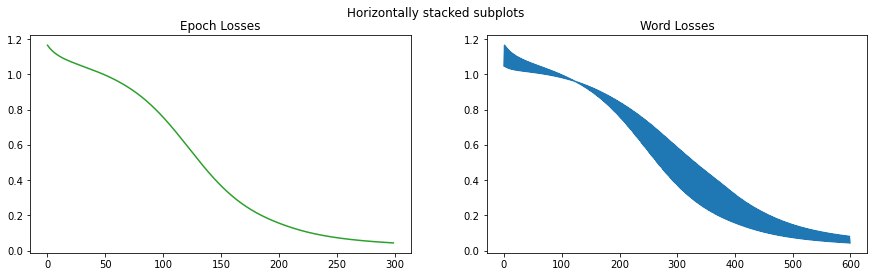

In [170]:
 
# Example training data:
training_data = [ 
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
enc = Encoder(training_data)

model = exec_trial(training_data, enc=enc)

# See what the scores are after training
with torch.no_grad():
    inputs = enc.sequence_words(training_data[0][0])
    tag_scores = model(inputs.to(device))

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(inputs)
    print(tag_scores)
    
assert str(inputs) == """tensor([0, 1, 2, 3, 4])"""
assert str(tag_scores.to('cpu')) == """tensor([[-0.0259, -4.5027, -4.2358],
        [-4.5316, -0.0617, -3.0154],
        [-2.6551, -2.9622, -0.1301],
        [-0.1583, -3.9917, -2.0562],
        [-4.2915, -0.0241, -4.5954]])"""


print('Unit test successful! :)')

C:\Users\Daglemino\Anaconda3\envs\dasi\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 4, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss = 0.26555222272872925
Epoch 1 loss = 0.26313287019729614
Epoch 2 loss = 0.2607865631580353
Epoch 3 loss = 0.2585119605064392
Epoch 4 loss = 0.25630760192871094
Epoch 5 loss = 0.2541719973087311
Epoch 6 loss = 0.2521035671234131
Epoch 7 loss = 0.250100702047348
Epoch 8 loss = 0.2481616884469986
Epoch 9 loss = 0.24628494679927826
Epoch 10 loss = 0.24446865916252136
Epoch 11 loss = 0.2427111566066742
Epoch 12 loss = 0.24101075530052185
Epoch 13 loss = 0.23936572670936584
Epoch 14 loss = 0.2377742975950241
Epoch 15 loss = 0.2362349033355713
Epoch 16 loss = 0.23474575579166412
Epoch 17 loss = 0.23330527544021606
Epoch 18 loss = 0.2319118082523346
Epoch 19 loss = 0.23056377470493317
Epoch 20 loss = 0.22925962507724762
Epoch 21 loss = 0.2279978096485138
Epoch 22 loss = 0.2267768681049347
Epoch 23 loss = 0.22559531033039093
Epoch 24 loss = 0.22445176541805267
Epoch 25 loss = 0.2233448624610901
Epoch 26 loss = 0.22227324545383453
Epoch 27 loss = 0.22123563289642334
Epoch 28 loss = 

Epoch 241 loss = 0.12338972091674805
Epoch 242 loss = 0.1226690411567688
Epoch 243 loss = 0.1219482570886612
Epoch 244 loss = 0.12122759222984314
Epoch 245 loss = 0.12050717324018478
Epoch 246 loss = 0.11978716403245926
Epoch 247 loss = 0.11906775087118149
Epoch 248 loss = 0.11834906041622162
Epoch 249 loss = 0.11763129383325577
Epoch 250 loss = 0.11691458523273468
Epoch 251 loss = 0.1161990538239479
Epoch 252 loss = 0.11548492312431335
Epoch 253 loss = 0.11477230489253998
Epoch 254 loss = 0.11406133323907852
Epoch 255 loss = 0.1133522018790245
Epoch 256 loss = 0.1126449927687645
Epoch 257 loss = 0.11193985491991043
Epoch 258 loss = 0.11123697459697723
Epoch 259 loss = 0.11053642630577087
Epoch 260 loss = 0.10983837395906448
Epoch 261 loss = 0.10914288461208344
Epoch 262 loss = 0.10845017433166504
Epoch 263 loss = 0.10776025056838989
Epoch 264 loss = 0.10707330703735352
Epoch 265 loss = 0.10638943314552307
Epoch 266 loss = 0.10570872575044632
Epoch 267 loss = 0.10503129661083221
Epoch 

Epoch 483 loss = 0.035023488104343414
Epoch 484 loss = 0.03489641100168228
Epoch 485 loss = 0.03477015346288681
Epoch 486 loss = 0.0346447117626667
Epoch 487 loss = 0.034520070999860764
Epoch 488 loss = 0.03439624607563019
Epoch 489 loss = 0.03427322208881378
Epoch 490 loss = 0.034150999039411545
Epoch 491 loss = 0.03402954712510109
Epoch 492 loss = 0.033908870071172714
Epoch 493 loss = 0.03378898650407791
Epoch 494 loss = 0.0336698442697525
Epoch 495 loss = 0.03355148807168007
Epoch 496 loss = 0.03343386575579643
Epoch 497 loss = 0.033316995948553085
Epoch 498 loss = 0.03320087864995003
Epoch 499 loss = 0.03308548405766487
Trial done! 


AssertionError: 

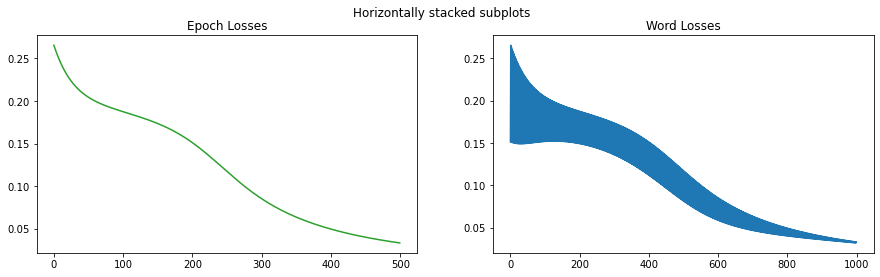

In [171]:
# Test training data: 
training_data = [ 
    ("The dog ate the apple".split(), torch.tensor([[1], [0], [0.5], [0.3], [1]])),
    ("Everybody read that book".split(), torch.tensor([[[0.2], [0], [1], [0]]]))
]
enc = Encoder(training_data)
model = exec_trial(
    training_data, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=500,
    enc=enc
)
      
# See what the scores are after training
with torch.no_grad():
    inputs = enc.sequence_words(training_data[0][0])
    pred1 = model(inputs.to(device)) 
    inputs = enc.sequence_words(training_data[1][0])
    pred2 = model(inputs.to(device))
          
#print(hash(str(pred1.cpu().detach().numpy())), hash(str(pred2.cpu().detach().numpy())))
assert hash(str(pred1.cpu().detach().numpy())) == 2423810420677829124#8299978301676431484
assert hash(str(pred2.cpu().detach().numpy())) == -5139078890918265923#4865758014180741225

print('Unit test successful! :)')

## 4. Training and Predicting the Sentiment Score ##

Let's split our data 90% traing and 10% test data...

In [205]:
import random 

def list_splitter(list_to_split, ratio):
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return [list_to_split[:middle], list_to_split[middle:]]


clean_training_data = []

for i, comment in enumerate(clean_comments):
    clean_training_data.append(
        (comment, torch.tensor([[clean_sentiments[i]]]*len(comment)))
    )
    
random.Random(66642999).shuffle(clean_training_data)
    
train, test = list_splitter(clean_training_data, 0.9)

print('Train / Test split:', len(train),'/',len(test))

Train / Test split: 6558 / 729


Now we are ready to train it!

Epoch 0 loss = 0.2765096426010132
Epoch 1 loss = 0.06251109391450882
Epoch 2 loss = 0.04847894236445427
Epoch 3 loss = 0.03814604505896568
Epoch 4 loss = 0.028826016932725906
Epoch 5 loss = 0.022294746711850166
Epoch 6 loss = 0.01925317384302616
Epoch 7 loss = 0.01633565127849579
Epoch 8 loss = 0.014122440479695797
Epoch 9 loss = 0.012407856993377209
Epoch 10 loss = 0.010804836638271809
Epoch 11 loss = 0.009785553440451622
Epoch 12 loss = 0.008721458725631237
Epoch 13 loss = 0.00810051616281271
Epoch 14 loss = 0.007349611259996891
Epoch 15 loss = 0.006783147808164358
Epoch 16 loss = 0.006281384266912937
Epoch 17 loss = 0.0053683798760175705
Epoch 18 loss = 0.004905675072222948
Epoch 19 loss = 0.004359012469649315
Trial done! 


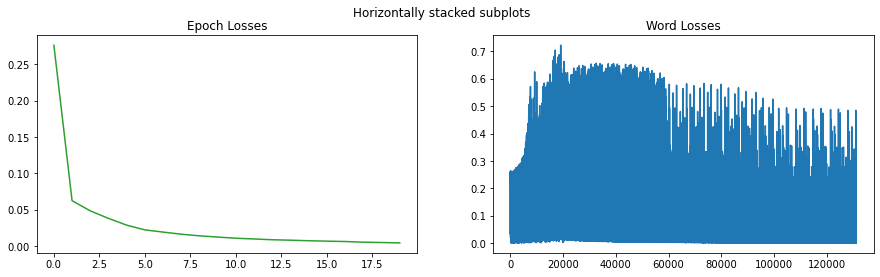

In [206]:

    
enc = Encoder(clean_training_data)
     

#model = exec_trial(
#    training_data=train, loss_function='mse', do_label_encode=False,
#    actifun='sigmoid', epochs=10, enc=enc, 
#)
 

model = exec_trial(
    training_data=train, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=20,
    enc=enc, 
    optimizer='adam',
    embedding_dim=32, # These is usually 32 or 64 dimensional.
    hidden_dim=128,# How large the lstm layer is...
    step_every_sentence=True 
)
#result = model.eval(test)
#print(result)


In [207]:
import time
date = str(time.time())
torch.save( model.state_dict(), 'models/lstm_model_state_dict_' + date ) 
torch.save( model,              'models/lstm_model_full_' + date ) 

# Model class must be defined somewhere
#model = torch.load(PATH)
#model.eval()

In [208]:
val_losses = []
loss_function = nn.MSELoss()

def evaluate_lstm(test_data):
    with torch.no_grad():
        for x_val, y_val in test_data: 
            model.eval() 
            sentence_in = enc.sequence_words(x_val).to(device)
            yhat = model(sentence_in)
            val_loss = loss_function(y_val.to(device), yhat)
            val_losses.append(val_loss.item())
            #if y_val.mean().item() < 0.5 or y_val.mean().item() > 0.999:
            print(' '.join(x_val),'\n-=> ',yhat.mean().item(),' should be ',y_val.mean().item(),'\n')
                
evaluate_lstm(test)

i'm not sorry | this is me. i'm not even mad 
-=>  0.06039723753929138  should be  0.025523068383336067 

joe rants about la coronavirus shutdowns | high laughing hard laughing hard 
-=>  0.9420381784439087  should be  0.9999196529388428 

i'm not sorry | lol this whole vid is scary ... 
-=>  0.069024957716465  should be  0.026287319138646126 

the kiffness - ievan polkka ft. bilal göregen (club remix) [official video] | i'm the cat for all 
-=>  0.9882286787033081  should be  0.9999352693557739 

phd biologist destroys vegan activist! | i am sorry but this guy just me of the person from english xd 
-=>  0.9285776019096375  should be  0.7799338698387146 

anita sarkeesian on gamergate and sexism | the scarlet letter reports | she's the real life 
-=>  0.08717568963766098  should be  0.24414852261543274 

generative adversarial networks (gans) - computerphile | for some someone says 'the have understanding of some i get and out at the same time. 
-=>  0.9913412928581238  should be  0.99

-=>  0.9668790102005005  should be  0.9802991151809692 

die karte der mathematik | this is what i’ve been loking this is amazing! 
-=>  0.985821545124054  should be  0.9998877644538879 

divergenz und rotation: die sprache der maxwellschen gleichungen, flüssigkeitsstrom, und mehr | i'd love to see one on the 
-=>  0.9753292798995972  should be  0.9999064207077026 

die argumente eines fleischessers für veganismus | had to come back to hear this part this was the most part to me. 
-=>  0.9909831285476685  should be  0.9997215867042542 

james gosling: java, jvm, emacs, and the early days of computing | lex fridman podcast #126 | i tok both and programming to my mind in nothing makes learning than the 
-=>  0.9864133596420288  should be  0.9877504706382751 

sadak 2 | official trailer | sanjay | poja | alia | aditya | jisshu | mahesh bhatt | 28 aug | i my just to make and dislike it 
-=>  0.046316392719745636  should be  0.0025626597926020622 

phd biologist destroys vegan activist! | b

-=>  0.05527232587337494  should be  0.08863938599824905 

youtube rewind: the shape of 2017 | #youtuberewind | who all are here mr 2020 rewind to gotta say was a 
-=>  0.9714290499687195  should be  0.8950468897819519 

january sales bean! | mr bean funny clips | mr bean official | happy new year from 
-=>  0.9856974482536316  should be  0.988095223903656 

exploring shillong | shot diaries | mr. faisu | people are faisu is on <3 
-=>  0.052433185279369354  should be  0.042496245354413986 

jacob sartorius - sweatshirt (official music video) | 3 years ago and i can still remember all the was not 
-=>  0.04307890683412552  should be  0.007953830063343048 

deep learned super-sampling (dlss) - computerphile | i guess he didn't mean but 
-=>  0.9318125247955322  should be  0.8055992722511292 

my favorite summer tops | girl your so beautiful but u need to eat 
-=>  0.9250566363334656  should be  0.7930536866188049 

in full: rowan atkinson on free speech | loud and long ... what they gon

cuties | official trailer | netflix | and ignore my genius netflix to make this stuff lol smh 
-=>  0.031328100711107254  should be  5.120120113133453e-05 

the real life of india ... | lana loks really cute in indian love thumbs up 
-=>  0.9886522889137268  should be  0.9995502233505249 

wrath of jodi | so no one is gonna talk about how just called her a on a and to show a of a that shit got me 
-=>  0.993414580821991  should be  0.9585362076759338 

trisha paytas talks backlash after transgender video | little did we know she would do the same thing to the community 
-=>  0.1080893948674202  should be  0.15142743289470673 

if programming was an anime part 2 | wow, you finally remember your youtube account 
-=>  0.9860458970069885  should be  0.5 

a day in our life (broke & teale) | broke the dog video: i’m everyone: no 
-=>  0.08347572386264801  should be  0.154172882437706 

i'm not apologizing | it’s at for me laughing hard laughing hard laughing hard laughing hard 
-=>  0.08057

sadak 2 | official trailer | sanjay | poja | alia | aditya | jisshu | mahesh bhatt | 28 aug | 2021 main dislike edit: thanks for the 
-=>  0.045887358486652374  should be  0.002581800799816847 

can this video get 1 million dislikes? | u got than u for lol 
-=>  0.04899318516254425  should be  4.632940181181766e-05 

asmr* stewed dog's thighs. extremely delicious and nutritious(eating sounds) no talking | vi asmr | oh she dogs and cats a year ago this was posted a ago 
-=>  0.04759832099080086  should be  0.07682852447032928 

ghostbusters - official trailer (hd) | how do they have the to keep it up with that 
-=>  0.040328819304704666  should be  0.0008638189174234867 

after earth official trailer #1 (2013) - will smith movie hd | i remember i made a plot like this in ... 
-=>  0.9850732684135437  should be  0.9837019443511963 

can this video get 1 million dislikes? | at the everything 
-=>  0.057159435003995895  should be  4.301652006688528e-05 

joe rants about la coronavirus shut

-=>  0.03150983899831772  should be  0.00419220793992281 

i'm sorry | “i’m not sorry” “i’m sorry” 
-=>  0.05495230108499527  should be  0.07088931649923325 

why you need to shift your focus | broke houts | we know you go 
-=>  0.053809843957424164  should be  0.0036269770935177803 

khaali peeli | teaser | ishaan | ananya panday | maqbol khan | coming son | what a and 
-=>  0.03330724313855171  should be  0.00011755018931580707 

if programming was an anime part 2 | everyone talking about death did no one the at some 
-=>  0.9883715510368347  should be  0.9998210072517395 

parallel worlds probably exist. here’s why | in some parallel i everything in the video. a version of me, but yeah, that makes me happy 
-=>  0.9653865098953247  should be  0.9915755987167358 

joe rants about la coronavirus shutdowns | remember when you could watch full on youtube & comment with your i 
-=>  0.965222954750061  should be  0.999919593334198 

my apology | all that money just to film with a 
-=>  0.

rowan atkinson live - drunks in an indian restaurant | 13 2020 ... and he still the best of the best laughing 
-=>  0.994490385055542  should be  0.9999624490737915 

neujahrsansprache 2021 von bundeskanzlerin angela merkel | ich in es 
-=>  0.8335512280464172  should be  0.6807088255882263 

sentiment analysis python - 6 - - natural language (nlp) | can you use the same for ? 
-=>  0.9193739295005798  should be  0.75 

neujahrsansprache 2021 von bundeskanzlerin angela merkel | man 
-=>  0.798489511013031  should be  0.8119803071022034 

milchbauer zerstört veganen aktivisten! | your doing well laughing laughing laughing laughing laughing laughing laughing he tok the 
-=>  0.8231457471847534  should be  0.7289122939109802 

magnets and marbles | your house is at a weird 
-=>  0.9796233177185059  should be  0.5 

the case of lee rodarte | phone 
-=>  0.972805380821228  should be  0.9998273253440857 

magnets and marbles | million interesting 
-=>  0.9660415649414062  should be  0.998187

Now that we trained the model...<br>
Let's feed it some custom sentences and see what it predicts! :)

In [236]:

my_sentences = [ 
    ( 'eating a dog alive | i hate this bad video it is very bad'.split(), 0 ), 
    ( 'eating a cat alive | oh my god this could be my dear'.split(), 0 ), 
    ( 'january sales bean! | happy new year from india'.split(), 1 ),
    ( 'my favorite cat does nothing | great video much love every day'.split(), 1 )
]

my_sentences = list(
    map( 
        lambda s: (
            s[0], 
            torch.tensor( [[s[1]]]*len(s[0]), dtype=torch.float32, device=device) 
        ),
        my_sentences 
    )
)
  
print(evaluate_lstm(my_sentences))

eating a dog alive | i hate this bad video it is very bad 
-=>  0.1231556311249733  should be  0.0 

eating a cat alive | oh my god this could be my dear 
-=>  0.13245069980621338  should be  0.0 

january sales bean! | happy new year from india 
-=>  0.9732221961021423  should be  1.0 

my favorite cat does nothing | great video much love every day 
-=>  0.9217771291732788  should be  1.0 

None


 ---
 
 # Doing some good old Logistic Regression #
 
 
 ## 1. Bag of Words ##
 
 Although we already cleaned your data very thoroughly, for this approach we need
 to go even further! <br>
 We are going to use the `nltk` library in order to remove so called **"stopword"**, 
 which are very commen words that don not carry significant meaning...<br>
 ...and we are also going to convert the remaining words into their root form so that we reduce
 the noise in our data even more!<br>
 
In the English language, words can take multiple different forms depending upon where and how we use them. 
Lemmatizing is a process of bringing all different forms of a word to its root form so that machine looks at them as similar words.

For example- {‘keep’, ‘keeping’, ‘keeper’, ‘keeps’} will be reduced to a single word-‘keep’. 

In [131]:
import re
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
lemmatizer = nltk.stem.WordNetLemmatizer()

english_stop_words = nltk.corpus.stopwords.words('english')
print('Stop word in the english language:',len(english_stop_words))
print("'Let's take a look at a couple:\n")
print(' | '.join(english_stop_words[:25]),'...')


def keep_only_letters(word):
    word=re.sub(r'[^a-zA-Z\s]','',word)
    return word
 
def convert_to_lowercase(word):
    return word.lower()
 
def remove_stop_word(word):
    for stopword in english_stop_words:
        if word == stopword:
            return None
    return word

def lemmatize_word(word):
    #stemmer = nltk.porter.PorterStemmer()
    #stemmed = stemmer.stem(word)
    lemmared = lemmatizer.lemmatize(word)
    return lemmared
    
def clean_comment_further(text): 
    cleaned = []
    for word in text:
        word = keep_only_letters(word)
        word = convert_to_lowercase(word)
        word = remove_stop_word(word)
        if word != None and word != '' : 
            word = lemmatize_word(word)
            cleaned.append(word)
    return cleaned
 

Stop word in the english language: 179
'Let's take a look at a couple:

i | me | my | myself | we | our | ours | ourselves | you | you're | you've | you'll | you'd | your | yours | yourself | yourselves | he | him | his | himself | she | she's | her | hers ...


Now that we defined the methods for polishing the data, we now apply them and create carrier variables, namely:


- `train_X`, `train_Y` 
- `test_X`, `test_Y` 

Previously the training and test data we used for our neural networ
was a list of tuples which contained the X and Y values... <br>
Now we want to work with scikit-learn models so we have to convert these<br>
train test lists to these new variables: 

In [132]:
train_X, train_Y = [], []
test_X, test_Y = [], []

for x, y in train: 
    train_X.append(' '.join(clean_comment_further(x)))
    train_Y.append(y.mean().item())
    
for x, y in test:
    test_X.append(' '.join(clean_comment_further(x)))
    test_Y.append(y.mean().item())
  
print('Number of comments for training:',len(train_X))
print('Number of comments for testing:',len(test_X))

Number of comments for training: 5097
Number of comments for testing: 567


...hardly readable for us, but easy to encode for the computer! :)

## 2. Vectorization & Training ##

Now we use a vectorizer from the scikit-learn library to encode the text data...<br>
Then we binarize the sentiments and fit the `sklearn.linear_model.LogisticRegression()` model!

In [133]:

import sklearn
import sklearn.feature_extraction
import sklearn.linear_model

vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))

tf_features_train = vectorizer.fit_transform(train_X)
tf_features_test = vectorizer.transform(test_X)
print('Feature shapes of train / test arrays:',tf_features_train.shape,'/', tf_features_test.shape)

train_labels = [1 if sentiment > 0.85 else 0 for sentiment in train_Y]
test_labels = [1 if sentiment > 0.85 else 0 for sentiment in test_Y]
print('Number of train & test labels: ',len(train_labels),'/', len(test_labels))

clf = sklearn.linear_model.LogisticRegression()
clf.fit(tf_features_train, train_labels)
print ('Model used:',clf)

Feature shapes of train / test arrays: (5097, 690) / (567, 690)
Number of train & test labels:  5097 / 567
Model used: LogisticRegression()


## 3. Evaluation #

Finally we do some predictions and calculate informative metrics for them!

In [134]:
predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

    Negative       0.66      0.75      0.70       295
    Positive       0.68      0.58      0.63       272

    accuracy                           0.67       567
   macro avg       0.67      0.67      0.66       567
weighted avg       0.67      0.67      0.67       567

[[221  74]
 [114 158]]


The accuracy is not bad, especially because of the fact that the amouont of data we used was rather small...<br>
Let's look at the binary predictions:

In [135]:
print(predictions)

[0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0
 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0
 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0
 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1
 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 1 1 1 0 0 0 0 

---

# Associating sentiments with words! #

The bag of words approach we tested previously leads us to another
strategy, based on the following question: <br>

- What if we calculate a fixed sentiment for every word?

Doing so would allow us to create a dictionary of words with an associated
sentiment. <br>
This dictionary could then be used to predict the sentiment of
whole sentences by simply calculating the average of the sentiments
of the words of a given sentence... <br>
Just like the previous approach this would ignore grammer as well
as the real meaning of a given sentence. <br>
However, for simple comments which contain words like "hate", "love", "good", "bad"... 
this approach might actually yield very good results!<br>

**Let's try it out!**

First we define a method which calculates a word-sentiment dictionary:

In [136]:

def train_word_sentiments(X, Y):
    word_sentiments = dict()
    for i, sentence in enumerate(X):
        words = sentence.split()
        sentiment = Y[i]
        for word in words:
            if word not in word_sentiments:
                word_sentiments[word] = (1, sentiment)
            else:
                count, accum_sent = word_sentiments[word]
                word_sentiments[word] = (count+1, accum_sent+sentiment)   
    final_word_sentiments = dict()
    for word, data in word_sentiments.items():
        count, accum_sent = data
        final_word_sentiments[word] = accum_sent / count
        
    return final_word_sentiments


Then we define a method which can do predictions based on such a dictionary:

In [137]:
def predict_sentence_by_words(word_sentiments, X, Y):
    pred = []
    for i, sentence in enumerate(X):
        words = sentence.split()
        sentiment = Y[i]
        sentiment_pred = 0
        count = 0
        for word in words:
            if word in word_sentiments:
                count += 1
                sentiment_pred += word_sentiments[word]
        
        if count>0 : pred.append(sentiment_pred/count)
        else : pred.append(0.5)
    return pred

And lastly, we train and test the concept with the previously 
created data, namely: <br>

- `train_X`, `train_Y` 
- `test_X`, `test_Y` 

In [138]:
    
word_sentiments = train_word_sentiments(train_X, train_Y)
predictions = predict_sentence_by_words(word_sentiments, test_X, test_Y)

loss = 0
for i, pred in enumerate(predictions):
    if test_Y[i]<0.5 or test_Y[i] > 0.9999:
        print(test_X[i],'\n-=> ',pred,' should be ',test_Y[i])
    loss += abs(pred-test_Y[i])
loss = loss / len(predictions)
print('====================================')
print('| Average loss:', loss)
print('====================================')

think wasnt wasnt actually fan got offended instead taking 
-=>  0.5511681488641598  should be  0.005543788895010948
almost made cry said year ago new need ghostbusters ghostbusters 
-=>  0.49811812257625376  should be  0.0008638189174234867
remember live video video worse 
-=>  0.5746587506678773  should be  0.025253335013985634
let girl say chicken 
-=>  0.44936761504750367  should be  0.39319565892219543
hope great god saw new video 
-=>  0.670860892064166  should be  0.10151058435440063
thats speaking accent 
-=>  0.8234921127178048  should be  0.9999623894691467
thats love 
-=>  0.6895127532013978  should be  0.9999623894691467
que rip quem placa 
-=>  0.18390488418566142  should be  0.0017405112739652395
ppl dont even want wear 
-=>  0.5236521329078927  should be  0.9999196529388428
like year half ppl movie 
-=>  0.545277116411711  should be  3.8812082493677735e-05
thinking people shes everyone brain know probably abusing por dog 
-=>  0.4182225086345738  should be  0.00087893987

**This approach works surprisingly well!**